# Assignment Graph Visualization
### DATA 620 <br> David Moste &emsp; Euclid zhang &emsp; Samuel Reeves <br>6/3/2021

Presentation Video Link: TD

Import required libraries

In [92]:
import requests
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Data Description

Data Source: https://snap.stanford.edu/data/email-EuAll.html
<br><br>
Our data is a network representing the emails sent in an European research institution from October 2003 to May 2005. Each directed edge represents that there is at least one email sent from node 1 (user 1) to node 2 (user 2)

### Data Preparation

The data is stored in a text file. First, we read the data file into the system, then split them in to lines. The first 3 lines contains data descriptions

In [93]:
response = requests.get("https://raw.githubusercontent.com/ezaccountz/Data_620/main/week%202%20part%201/Email-EuAll.txt").text
[line for line in response.split("\n")[:3]]

['# Directed graph (each unordered pair of nodes is saved once): Email-EuAll.txt ',
 '# Email network of a large European Research Institution (directed edge means at least one email was sent between October 2003 and March 2005)',
 '# Nodes: 265214 Edges: 420045']

The 4th line contains the column names of the data: FromNodeId and ToNodeId. The last line is blank. <br>
Therefore, we only need from line 5 to the second last line in the text file

In [94]:
lines = response.split("\n")[4:-1]

Each line represents a directed edge. <br>
The first number is the the source node ID (sender of an email)<br>
The second number is the target node ID (receiver of the email)<br>
The two nodes are separated by a '\t' (tab character).<br>
Then convert the node IDs to int for smaller storage and easier calculation

In [95]:
data_full = pd.DataFrame(data = [n.split("\t") for n in lines], columns = ['from','to'])
data_full['from'] = [int(i) for i in data_full['from']]
data_full['to'] = [int(i) for i in data_full['to']]
data_full

,from,to
0,0,1
1,0,4
2,0,5
3,0,8
4,0,11
...,...,...
420040,265209,422
420041,265210,422
420042,265211,192
420043,265212,875


Since the dataset is too large, we are going to select a small subset for the analysis. Use the n_subset variable to set up the number of nodes in the subset

In [96]:
n_subset = 500

Filter the edges connecting only the first n_subset nodes 

In [97]:
data_sub = data_full[data_full['from'] < n_subset]
data_sub = data_sub[data_sub['to'] < n_subset]
data_sub = data_sub.reset_index(drop=True)
data_sub

,from,to
0,0,1
1,0,4
2,0,5
3,0,8
4,0,11
...,...,...
2951,497,452
2952,497,455
2953,497,457
2954,497,496


Now, we create a directed graph using the finished dataframe

In [98]:
g = nx.from_pandas_edgelist(data_sub, 'from', 'to', create_using=nx.DiGraph())

The number of nodes is

In [99]:
nx.number_of_nodes(g)

499

The total number of nodes is 499, it seems like there is one node ID not included in the FromNodeId list

The number of directed edges is

In [100]:
nx.number_of_edges(g)

2956

Let's check if there are any isolated groups

In [101]:
pd.Series([len(c) for c in sorted(nx.strongly_connected_components(g), key=len)]).value_counts()

1      239
2        4
252      1
dtype: int64

The main connected group contains 252 nodes, which the remaining group contains only 1 or 2 nodes

We will focus on the main group lcc (largest connected component)

In [102]:
largest_cc = max(nx.strongly_connected_components(g), key=len)

#The following should be used instead for undirected graph
#g = nx.from_pandas_edgelist(data_sub, 'from', 'to')
#pd.Series([len(c) for c in sorted(nx.connected_components(g), key=len)]).value_counts()
#largest_cc = max(nx.connected_components(g), key=len)

In [103]:
lcc = g.subgraph(largest_cc).copy() 

again, the number of nodes in the lcc is 

In [104]:
nx.number_of_nodes(lcc)

252

The number of edges in the lcc is

In [105]:
nx.number_of_edges(lcc)

2513

### Data Analysis

Now, let's calculate the diameter

In [106]:
nx.diameter(lcc)

7

The diameter, which is the longest path between two nodes connected indirectly, is 7. A small number indicates that the network is well connected. We may want to check some other measurements of the network's centrality to confirm that the network is indeed well connected.

Now, let check some centralities of our graph

In [107]:
summarys = pd.DataFrame(dict(
    DEGREE = dict(lcc.degree),
    DEGREE_CENTRALITY = nx.degree_centrality(lcc),
    EIGENVECTOR = nx.eigenvector_centrality(lcc), 
    CLOSENESS_CENTRALITY = nx.closeness_centrality(lcc),
    BETWEENNESS_CENTRALITY = nx.betweenness_centrality(lcc)
)) 
#code used is from 
#https://stackoverflow.com/questions/51974825/networkx-pandas-cant-output-the-degree-of-the-nodes-into-a-txt-file-error

In [108]:
summarys.sort_values(by = 'DEGREE', ascending = False)

,DEGREE,DEGREE_CENTRALITY,EIGENVECTOR,CLOSENESS_CENTRALITY,BETWEENNESS_CENTRALITY
314,127,0.505976,0.251725,0.496047,0.135286
10,100,0.398406,0.170728,0.470919,0.140121
192,97,0.386454,0.242733,0.463100,0.057408
175,81,0.322709,0.175969,0.447415,0.049527
240,76,0.302789,0.169645,0.458029,0.050219
...,...,...,...,...,...
124,2,0.007968,0.008210,0.320562,0.000000
249,2,0.007968,0.002581,0.285227,0.000000
141,2,0.007968,0.008210,0.320562,0.000000
127,2,0.007968,0.002575,0.280134,0.000000


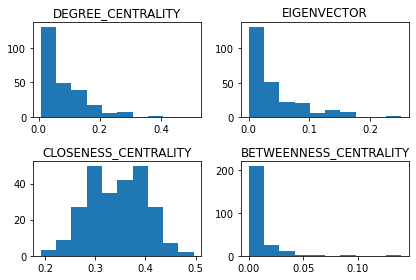

In [109]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(summarys['DEGREE_CENTRALITY'])
axs[0, 0].set_title('DEGREE_CENTRALITY')
axs[0, 1].hist(summarys['EIGENVECTOR'])
axs[0, 1].set_title('EIGENVECTOR')
axs[1, 0].hist(summarys['CLOSENESS_CENTRALITY'])
axs[1, 0].set_title('CLOSENESS_CENTRALITY')
axs[1, 1].hist(summarys['BETWEENNESS_CENTRALITY'])
axs[1, 1].set_title('BETWEENNESS_CENTRALITY')
fig.tight_layout() 
plt.show()

From the summary and plots, we can see that DEGREE_CENTRALITY, EIGENVECTOR and BETWEENNESS_CENTRALITY have high density near 0.<br> The CLOSENESS_CENTRALITY has a shape somewhat normal. 

We can also check the mean values of the centralities

In [110]:
summarys.mean()

DEGREE                    19.944444
DEGREE_CENTRALITY          0.079460
EIGENVECTOR                0.040200
CLOSENESS_CENTRALITY       0.341816
BETWEENNESS_CENTRALITY     0.008054
dtype: float64

### Conclusion

The results are indicating that the nodes in the network are not well connected to each other directly. However, they are well connected indirectly. <br>
People in a school may not know each other. They may not be aware that they are close to each other by the people they know mutally

Export the graph as a gefx file that can be used by Gephi or other programs for visualization

In [111]:
nx.write_gexf(lcc, 'E:/SPS/DATA 620/assignments/emails.gexf')